<a href="https://colab.research.google.com/github/AlexeyEvzrezov/DS_projects/blob/master/toxic_comment_classification/toxic_comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация токсичных комментариев

В рамках запуска нового сервиса, который позволит пользователям интернет-магазина редактировать и дополнять описания товаров, стоит задача создания инструмента для поиска токсичных комментариев и их отправки на модерацию.

В нашем распоряжении имеется набор данных с разметкой о токсичности правок. Обучим модель классифицировать комментарии на позитивные и негативные. 

Нам необходимо построить модель со значением метрики качества F1 не меньше 0.75.

## Содержание
- [Описание данных](#0)
1. [Загрузка и подготовка данных](#1)    
2. [Обучение](#2)    
- [Выводы](#3)

<a id="0"></a> 
## Описание данных
Признаки
- text - текст комментария
- toxic - метка токсичности комментария (целевой признак)

<a id="1"></a> 
## Загрузка и подготовка данных

In [ ]:
! pip install transformers

In [ ]:
! pip install simpletransformers

In [4]:
# импорт библиотек
import pandas as pd
import numpy as np

import plotly.express as px

from sklearn.model_selection import GridSearchCV, cross_val_score, \
                                    train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import transformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import torch

from tqdm import notebook

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re

nltk.download('stopwords')
nltk.download('wordnet')
eng_stopwords = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Загрузим данные и посмотрим на них.

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')                 

In [6]:
df.sample(5)

,text,toxic
59844,"""\n\nShe actually appeared in 3 episodes of """"...",0
8570,"the cunt, ya fucking old woman.",1
89590,"""\n\nWhen a numbered IP starts screwing with y...",0
73144,"""\n\nCambrian explosion and Timeline of evolut...",0
147198,"North Shoreman, which relevant and specific ar...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на распределение классов.

In [8]:
df.toxic.mean()

0.10167887648758234

Мы видим ощутимый дисбаланс - токсичных комментариев порядка 10%, однако это практически не представляет собой проблемы, т.к. целевой метрикой является F1-мера.

Проверим, как распределны комментарии по их длине и найдем максимальную длину комментария.

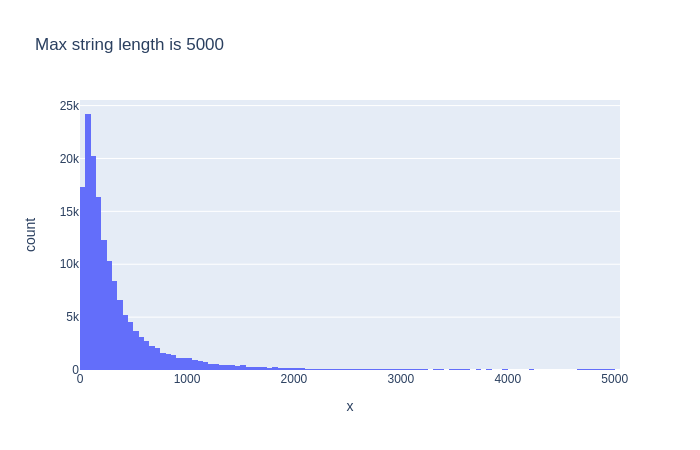

In [9]:
_ = df.text.str.len()
fig = px.histogram(x=_, nbins=100, title=f'Max string length is {_.max()}')
fig.show('png')

Приступим к обработке и преобразованию данных.

In [ ]:
def clean(text):
    '''
    Перерводит текст в нижний регистр,
    оставляет только слова,
    лемматизирует, убирает стоп-слова.
    '''
    wnl = WordNetLemmatizer()

    text = text.lower()
    #text = re.sub(r'(?:\n|\r)', ' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    words = text.split()
    words = [wnl.lemmatize(w) for w in words]
    words = [w for w in words if not w in eng_stopwords]
    
    res = ' '.join(words)
    
    return res

Добавим в датасет обработанные тексты.

In [ ]:
df = pd.concat([df, df.text.apply(clean)], axis=1 )
df.columns = ['text', 'toxic', 'lemmas']
df.head()

,text,toxic,lemmas
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Разделим данные на обучающую и отложенную выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('toxic', axis=1), 
                                                    df.toxic,
                                                    test_size=0.3,
                                                    random_state=0)

Создадим матрицу cо значениями TF-IDF.

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train.lemmas)
X_test_tfidf = tfidf.transform(X_test.lemmas)

<a id="2"></a> 
## 2. Обучение

### TF-IDF и логистическая регрессия

В качестве базовой модели используем логистическую регрессию.  
Подберем параметры по сетке на кросс-валидации.

In [ ]:
lr = LogisticRegression(random_state=0)
lr_params = dict(C=np.logspace(-2, 2, 5), 
                 tol=np.logspace(-5, -3, 3)
                 )
lr_grid = GridSearchCV(lr, param_grid=lr_params, scoring='f1', cv=5)

In [ ]:
lr_grid.fit(X_train_tfidf, y_train)
lr_grid.best_score_

0.7578163408432875

Проверим результаты на тестовой выборке.

In [ ]:
f1_score(y_test, lr_grid.predict(X_test_tfidf))

0.773630412311933

Как видим, целевое значение F1-меры превышено без усилий.  
Попробуем улучшить результаты с использованием более продвмнутых инструментов.

### Transformers

Создадим эмбеддинги с использованием BertTokenizerFast.
Чтобы ускорить процесс, ограничимся двадцатью тысячами объектов. Заранее отметим, как легко убедиться, работа с полным датасетом позволяет улучшить результаты, но незначительно. 

In [ ]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(df[:20000].shape[0] // batch_size)):
    tokenized = tokenizer(list(df[:20000].text[batch_size*i:batch_size*(i+1)]), 
                          padding=True, 
                          truncation=True, 
                          return_tensors='pt')
    batch = tokenized['input_ids'].to(device)
    attention_mask_batch = tokenized['attention_mask'].to(device)
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

features = np.concatenate(embeddings)

Посмотрим на значения F1-меры на кросс-валидации.


In [ ]:
cross_val_score(lr, features, df.toxic[:features.shape[0]], scoring='f1', cv=5)

array([0.71279373, 0.68870523, 0.69419355, 0.72279793, 0.67371202])

Мы получили не самые хорошие результаты. Отметим, что увеличивая размер обучающей выборки и подбирая гиперпараметры моделей мы можем добиться улучшений, однако результаты не будут ощутимо превышать тот уровень, который был получен нами в случае с TF-IDF и линейной регрессией. Для более значительного повышения качетсва имеет смысл обратиться к использованию нейронных сетей.

### SimpleTransformers

Чтобы максимально упростить задачу и получить неплохие результаты, можно воспользваться библиотекой SimpleTransformers.  
Проверим, что мы сможем получить.

In [ ]:
train, test = train_test_split(df.drop('lemmas', axis=1),
                               test_size=0.3,
                               random_state=0)

In [ ]:
model_args = ClassificationArgs(num_train_epochs=2,
                                do_lower_case=True,
                                no_save=True) 

model = ClassificationModel('bert', 'bert-base-uncased',
                            num_labels=2,
                            args=model_args
                            )

model.train_model(train, args={'overwrite_output_dir': True}) 

result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_score)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Выведем значение F1-меры для тестовой выборки.

In [ ]:
result['f1']

0.8355395531081226

Таким образом, прямо из коробки мы имеем значение F1-меры на уровне почти 0.84.


<a id="3"></a> 
## Выводы

В рамках данной работы мы рассмотрели задачу классификации комментариев на позитивные и негативные на основе набора данных с разметкой о их токсичности.

Мы реализовали несколько вариантов решения задачи:
- "ручная" предобработка текста с векторизацией TF-IDF;
- создание эмбеддингов при помощи предобученной модели BERT;
- и аналогичный вариант полностью из коробки средствами библиотеки SimpleTransformers.

Можно считать, что первый вариант с TF-IDF и линейной регрессией является наиболее подходящим для данной задачи, предполагающей достаточность F1-меры на уровне 0.75 (мы получили 0.77 на тестовой выборке) с учетом скорости его работы.  
Наилучший же по качеству стала модель из библиотеки SimpleTransformers с результатом 0.84.
